In [6]:
from __future__ import division

import os
import cv2
import copy
import glob
import shutil
import matplotlib
import numpy as np 
import mahotas as mh
import matplotlib.pyplot as plt    

import javabridge
import bioformats

import skimage
import skimage.io as io
import scipy.ndimage as ndi

from scipy.ndimage import imread
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.filters import threshold_otsu, threshold_local

% matplotlib inline

javabridge.start_vm(class_path=bioformats.JARS)

**Author:** Dhananjay Bhaskar

**Last Modified:** 05/04/2019

#### Objectives:
- Identify isolated nuclei by finding local maxima in distance transform
- Segment nuclei shape
    - measure morphology (area, perimeter, elongation)
- Count nuclei
    - upper bound (# markers) and lower bound (# of connected components) 
- Quantify P53 immunohistochemistry stain intensity inside nuclei vs. background
- [TODO] separate closely space (touching) nuclei

In [7]:
def create_montage(img_list):
    max_h = 0
    max_w = 0
    num_imgs = len(img_list)
    n_imgs_row = int(np.sqrt(num_imgs))
    n_imgs_col = int(np.floor(np.divide(num_imgs, n_imgs_row))) + 1
    for im in img_list:
        (h,w) = np.shape(im[1])
        if h > max_h:
            max_h = h
        if w > max_w:
            max_w = w
    max_dim = max(max_h,max_w)
    montage_width = n_imgs_row*max_dim
    montage_height = n_imgs_col*max_dim + 1
    montage = np.zeros((montage_height,montage_width))
    r_start = 0
    c_start = 0
    for im in img_list:
        (h,w) = np.shape(im[1])
        c_s = int(np.round(max_dim/2.0)) - int(np.round(w/2))
        r_s = int(np.round(max_dim/2.0)) - int(np.round(h/2))
        c_e = c_s + w
        r_e = r_s + h
        padded_im = np.zeros((max_dim,max_dim))
        padded_im[r_s:r_e,c_s:c_e] = im[1]
        #padded_im[int(max_dim/2),int(max_dim/2)] = 1
        montage[r_start:(r_start+max_dim),c_start:(c_start+max_dim)] = padded_im
        c_start += max_dim
        if c_start+max_dim > montage_width:
            c_start = 0
            r_start += max_dim
    return montage

#### Parameters
- Specify folder containing zvi files
- User-specified threshold for foreground/background separation per image

In [8]:
folder_name = 'O2'
img_thresh = [0.022, 0.016, 0.022, 0.022, 0.022, 0.022, 0.022, 0.022, 0.022, 0.022]

In [9]:
! rm -rf BigCSVFile.csv

Processing file: ./O2/h2ax_o2_2_1.zvi


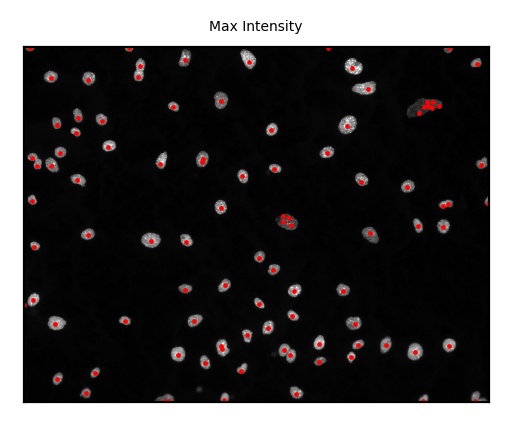

O2


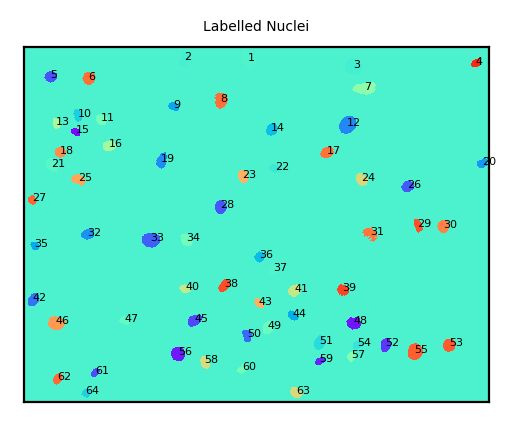

Number of nuclei found: 64
Number of nuclei markers: 78
Number of connected components: 71
Avg. pixel intensity for whole image: 0.0064401804
Avg. pixel intensity over all nuclei: 0.03443678701296449


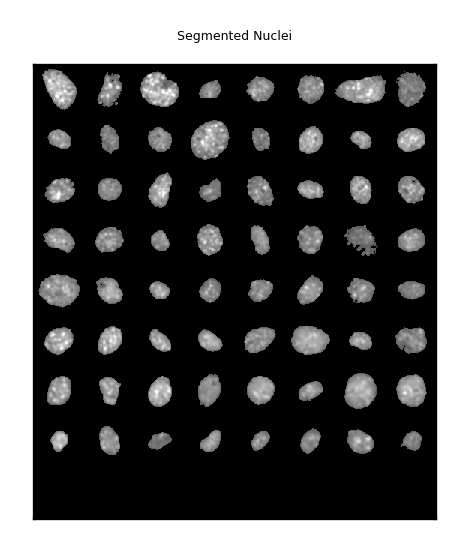

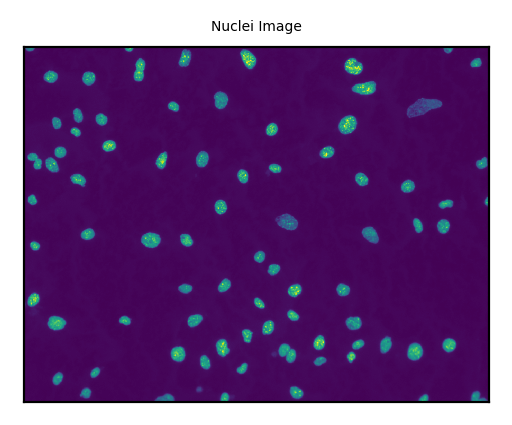




Processing file: ./O2/h2ax_o2_1_2.zvi


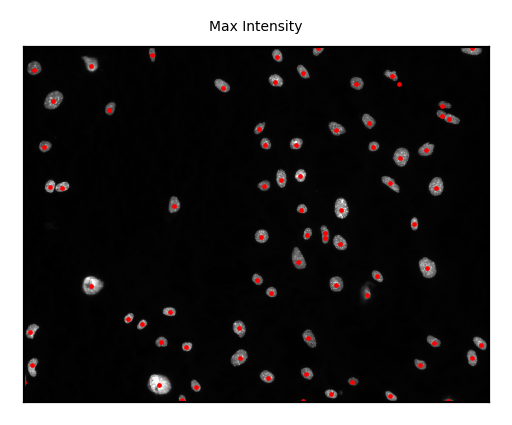

O2


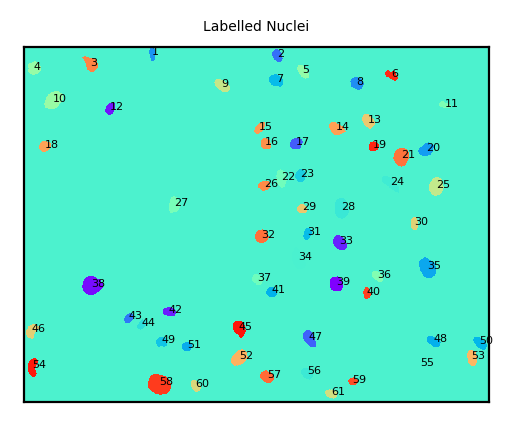

Number of nuclei found: 61
Number of nuclei markers: 67
Number of connected components: 64
Avg. pixel intensity for whole image: 0.0056240438
Avg. pixel intensity over all nuclei: 0.02980859214287312


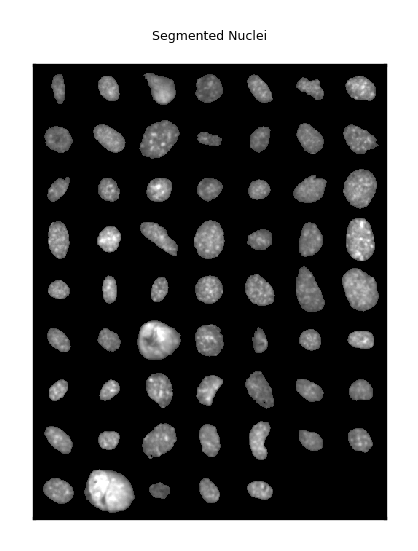

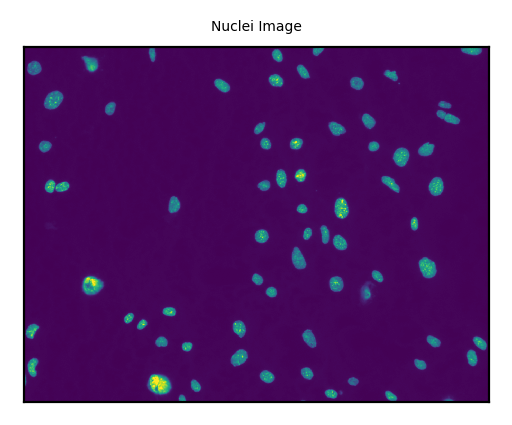




Processing file: ./O2/h2ax_o2_2_4.zvi


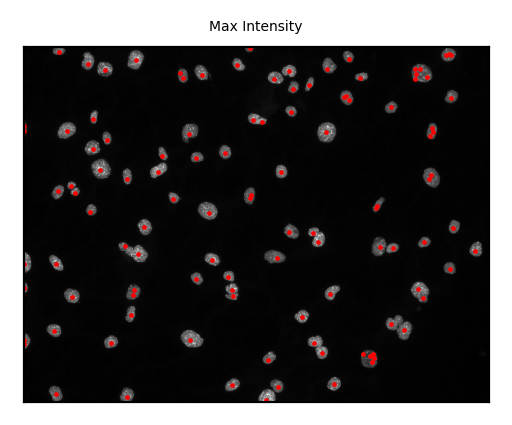

O2


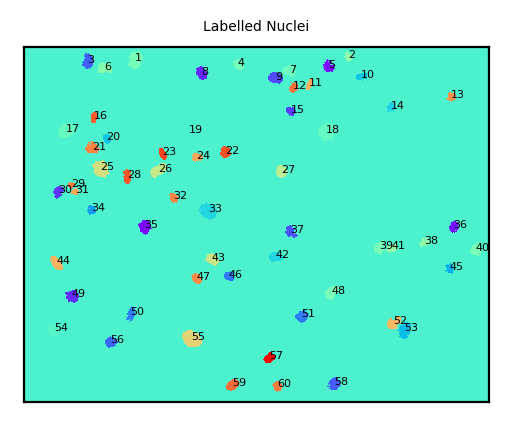

Number of nuclei found: 60
Number of nuclei markers: 99
Number of connected components: 76
Avg. pixel intensity for whole image: 0.0062241633
Avg. pixel intensity over all nuclei: 0.02857878152281046


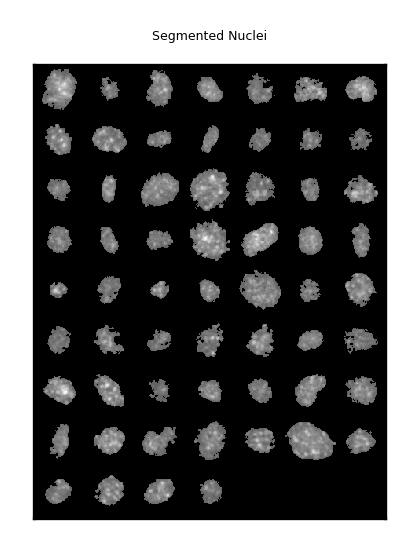

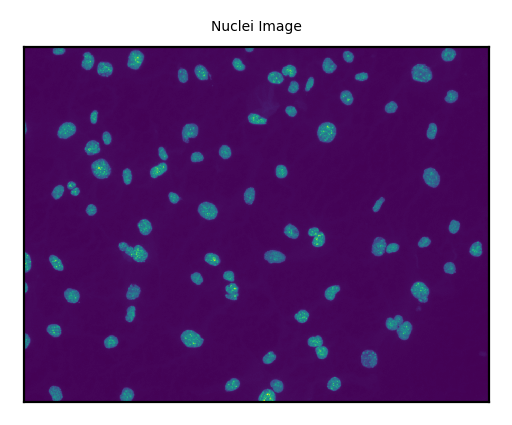




Processing file: ./O2/h2ax_o2_2_2.zvi


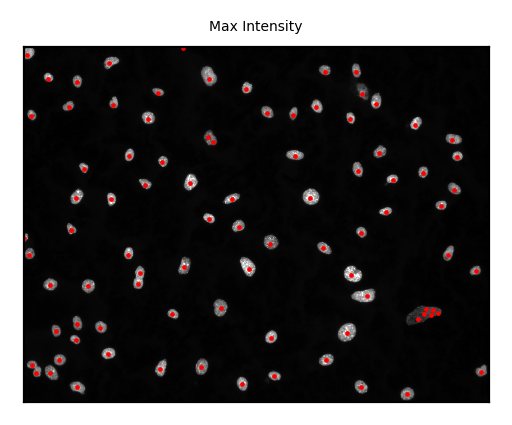

O2


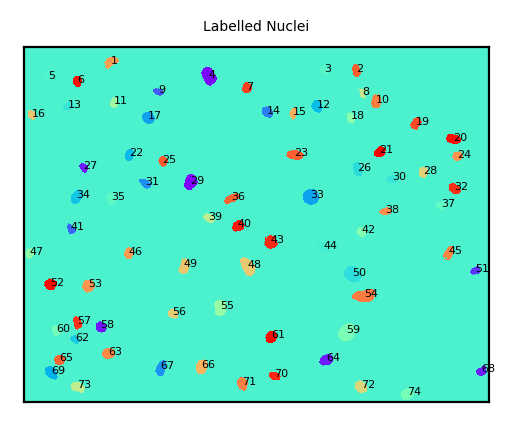

Number of nuclei found: 74
Number of nuclei markers: 80
Number of connected components: 77
Avg. pixel intensity for whole image: 0.006514266
Avg. pixel intensity over all nuclei: 0.03547603574052856


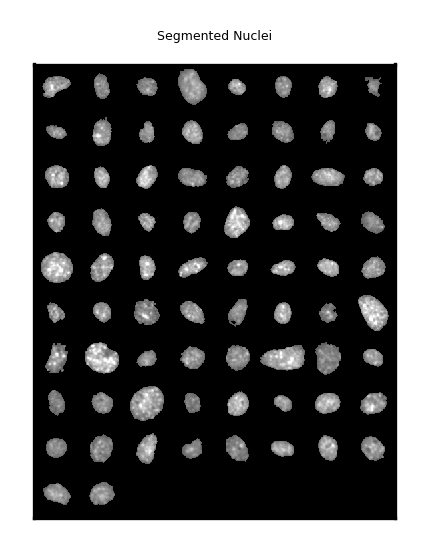

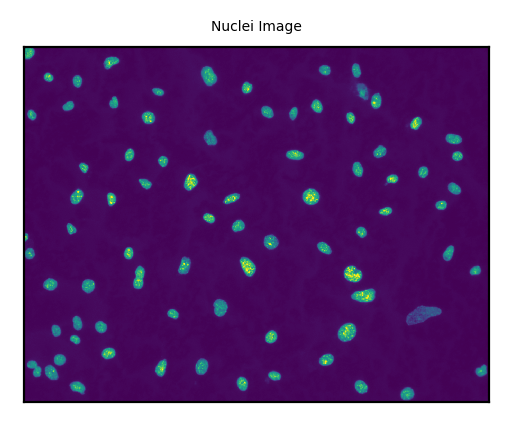




Processing file: ./O2/h2ax_o2_1_3.zvi


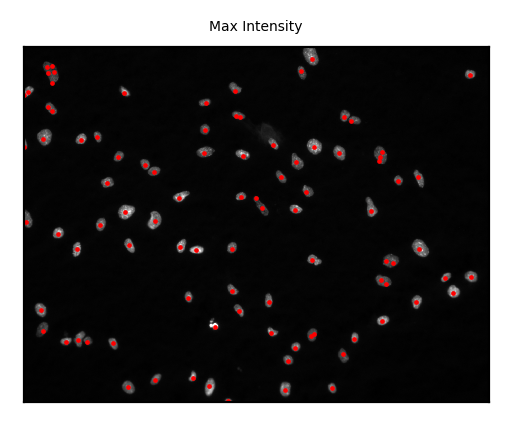

O2


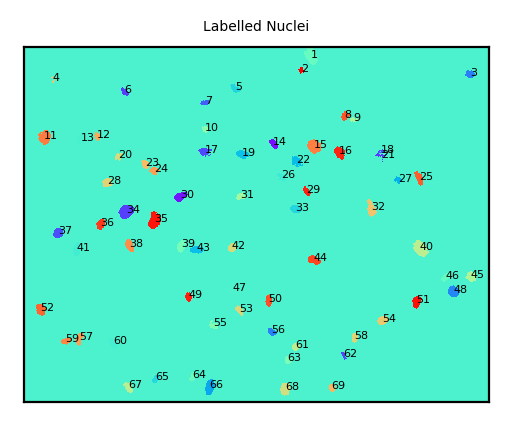

Number of nuclei found: 69
Number of nuclei markers: 79
Number of connected components: 74
Avg. pixel intensity for whole image: 0.006394402
Avg. pixel intensity over all nuclei: 0.03017117320627406


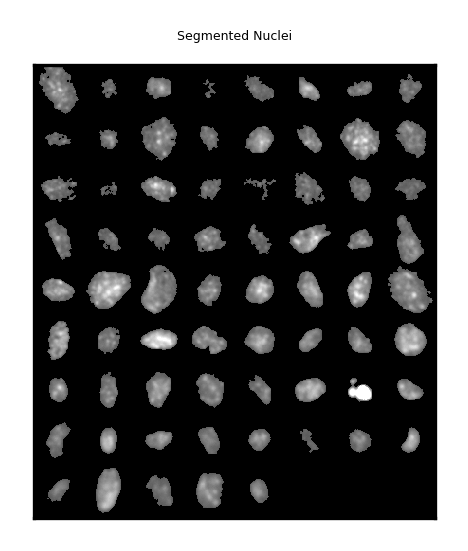

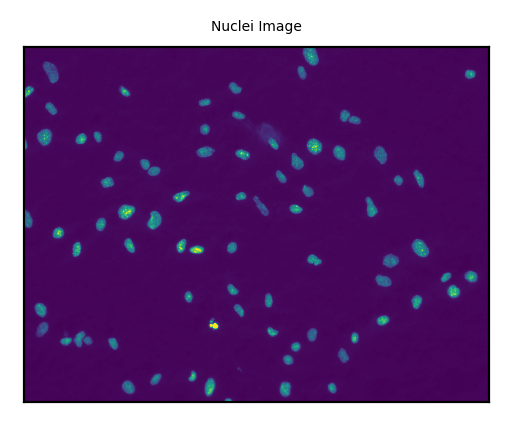




Processing file: ./O2/h2ax_o2_3_1.zvi


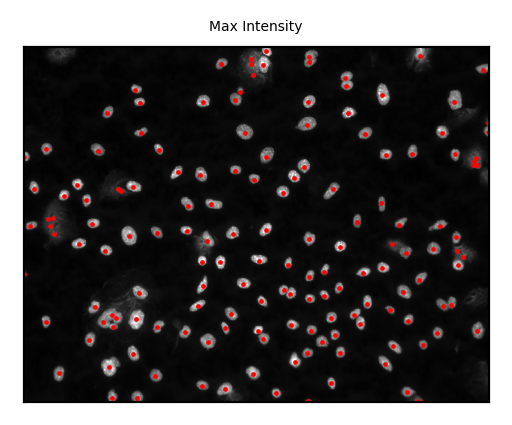

O2


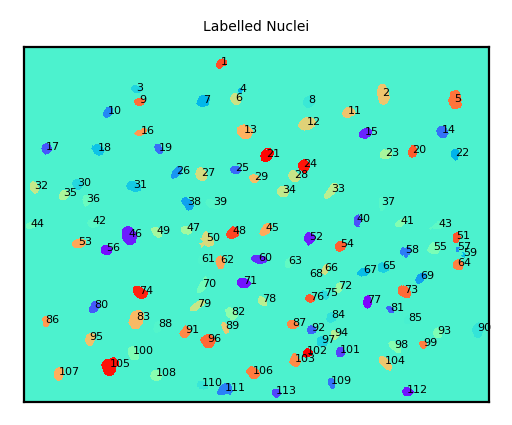

Number of nuclei found: 113
Number of nuclei markers: 136
Number of connected components: 122
Avg. pixel intensity for whole image: 0.009087003
Avg. pixel intensity over all nuclei: 0.03520842176754918


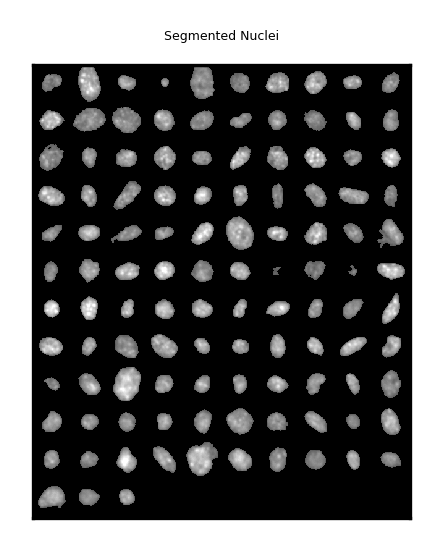

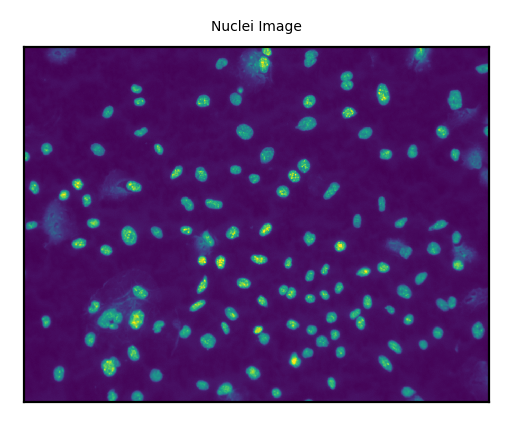




Processing file: ./O2/h2ax_o2_3_2.zvi


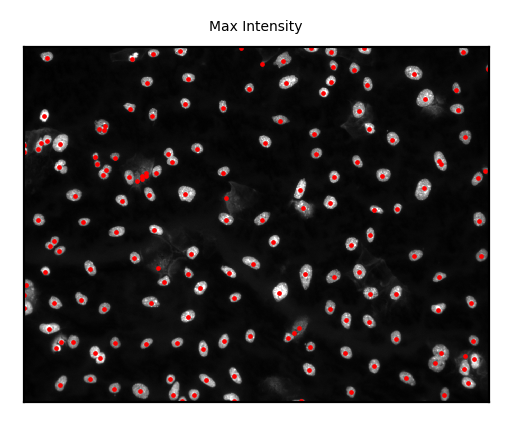

O2


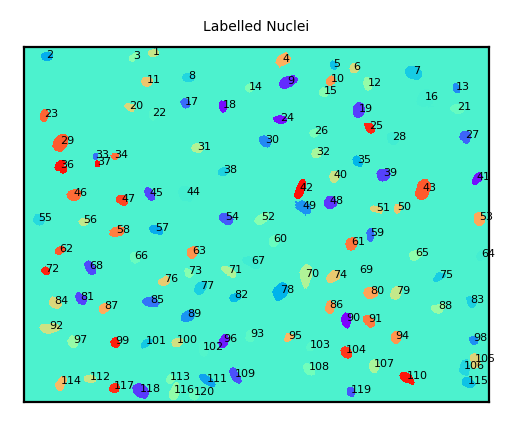

Number of nuclei found: 120
Number of nuclei markers: 149
Number of connected components: 132
Avg. pixel intensity for whole image: 0.010185434
Avg. pixel intensity over all nuclei: 0.038950529182329774


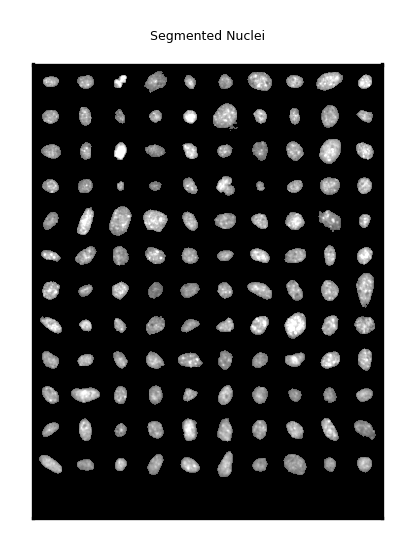

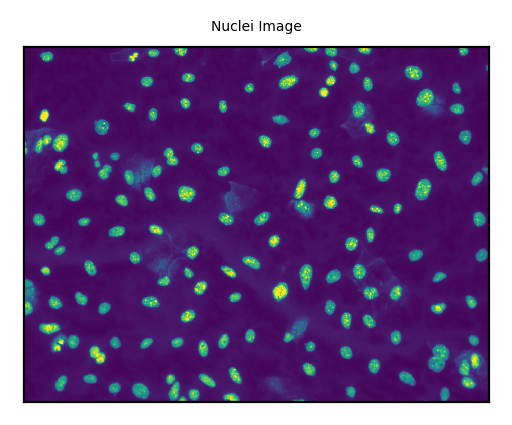




Processing file: ./O2/h2ax_o2_2_3.zvi


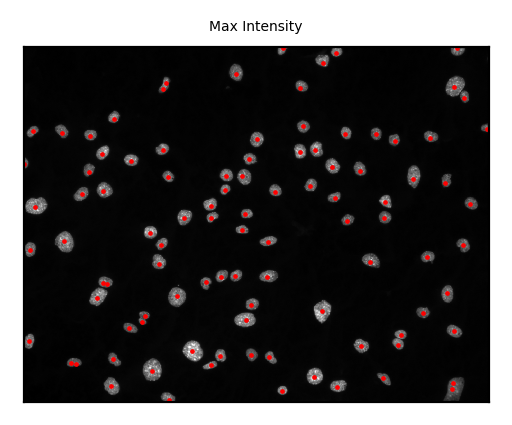

O2


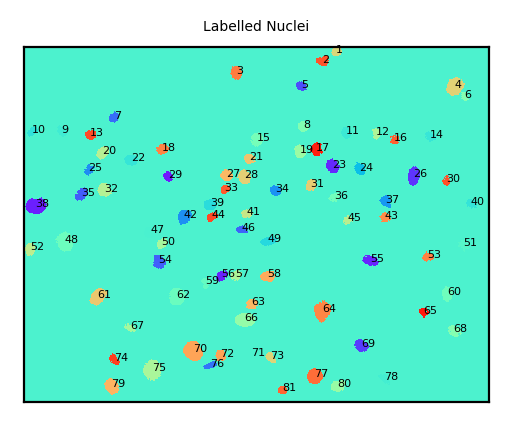

Number of nuclei found: 81
Number of nuclei markers: 93
Number of connected components: 87
Avg. pixel intensity for whole image: 0.006477342
Avg. pixel intensity over all nuclei: 0.029925527281047387


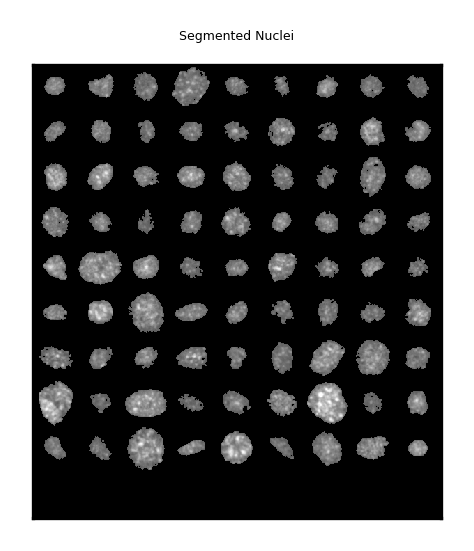

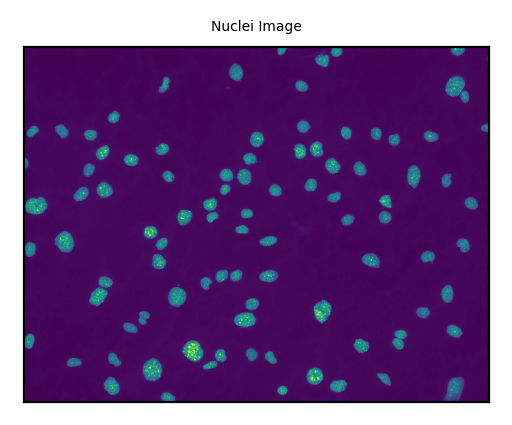




Processing file: ./O2/h2ax_o2_1_1.zvi


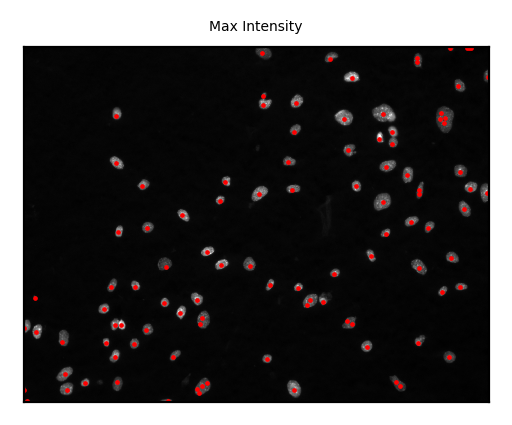

O2


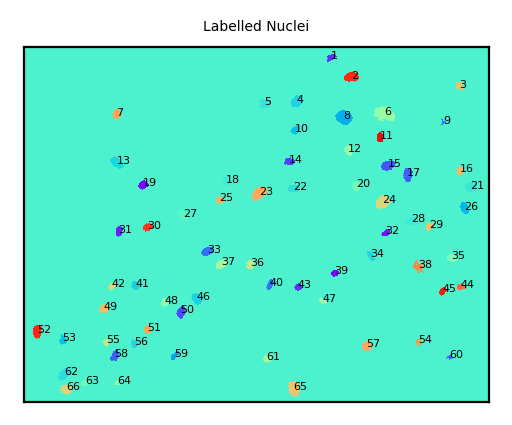

Number of nuclei found: 66
Number of nuclei markers: 85
Number of connected components: 75
Avg. pixel intensity for whole image: 0.0069790264
Avg. pixel intensity over all nuclei: 0.030258823976372227


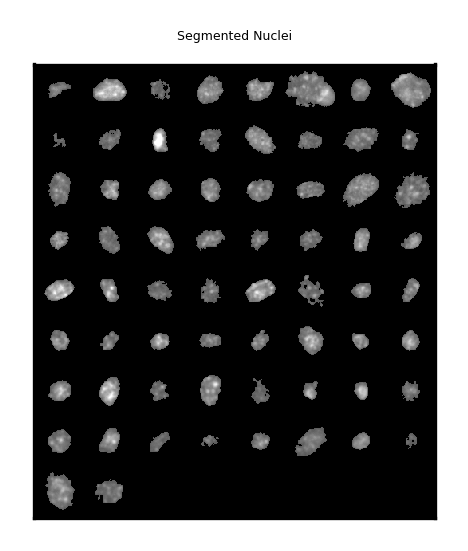

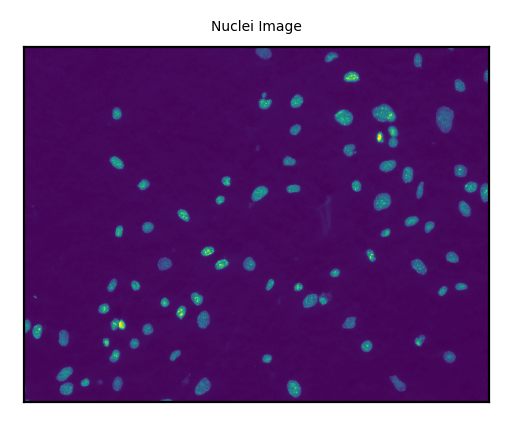




Processing file: ./O2/h2ax_o2_1_4.zvi


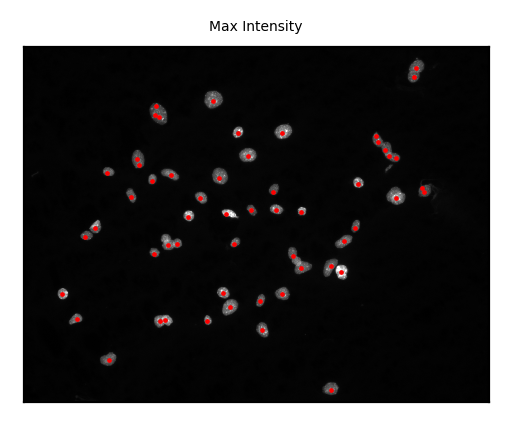

O2


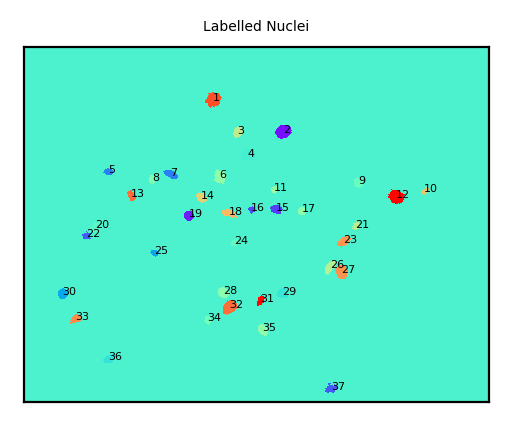

Number of nuclei found: 37
Number of nuclei markers: 55
Number of connected components: 44
Avg. pixel intensity for whole image: 0.0052542426
Avg. pixel intensity over all nuclei: 0.030509441939962877


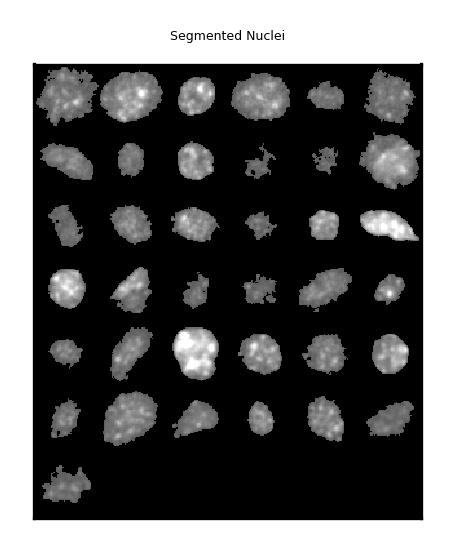

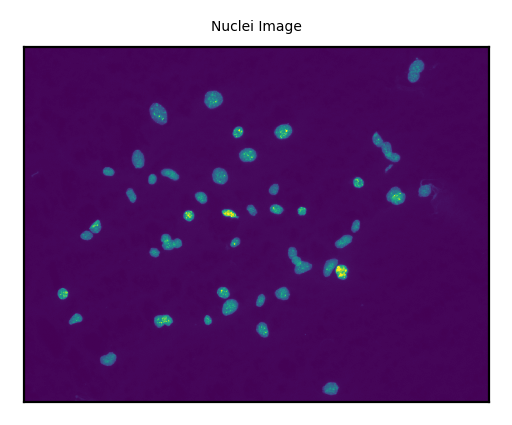

In [10]:
img_cnt = 0

all_out_fname = 'BigCSVFile.csv'
all_fh = open(all_out_fname, 'a')
all_fh.write('Image\tNucleus ID\tAvg. Intensity Inside Nucleus\n')

for zvi_file in glob.glob("./" + folder_name + "/" + "*.zvi")[:10]:
    
    print("Processing file: " + zvi_file)
    
    img_reader = bioformats.ImageReader(path=zvi_file)
    xml_metadata = bioformats.get_omexml_metadata(path=zvi_file)
    
    img_rdr = img_reader.rdr
    channel_separator = bioformats.ChannelSeparator(rdr=img_rdr)

    dim_order = channel_separator.getDimensionOrder()
    series_count = channel_separator.getSeriesCount()
    img_count = channel_separator.getImageCount()
    nchannels = channel_separator.getSizeC()
    nrows = channel_separator.getSizeY()
    ncols = channel_separator.getSizeX()
    nstacks = channel_separator.getSizeZ()
    
    img_array_c1 = bioformats.load_image(c=0, series=0, z=0, t=0, index=0, path=zvi_file)
    img_array_c2 = bioformats.load_image(c=0, series=0, z=0, t=0, index=1, path=zvi_file)

    (nrows, ncols) = np.shape(img_array_c1)
    
    composite = np.zeros((nrows, ncols, 3))
    composite[:,:,0] = img_array_c1/np.max(img_array_c1)
    composite[:,:,1] = img_array_c1/np.max(img_array_c1)
    composite[:,:,2] = img_array_c1/np.max(img_array_c1)
    
    # Use OpenCV
    scaled = composite * 255
    img = scaled.astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1.5, 30)
    
    # Binarize image
    bin_img = img_array_c1 > img_thresh[img_cnt]
    dt = ndi.distance_transform_edt(bin_img)
    dt = ndi.filters.maximum_filter(dt, size=5) 
    
    # Compute local maxima of distance transform
    reg_max = mh.morph.regmax(dt, Bc=np.ones((9,9)))
    label_image = skimage.measure.label(reg_max)
    x_max_coords = []
    y_max_coords = []
    for region in skimage.measure.regionprops(label_image):
        x_max_coords.append(int(region.centroid[0]))
        y_max_coords.append(int(region.centroid[1]))
        
    plt.figure(figsize=(3,3), dpi=200)
    plt.imshow(img_array_c1, cmap='gray', interpolation='none')
    plt.scatter(y_max_coords, x_max_coords, s=0.5, color='red')
    plt.xticks([])
    plt.yticks([])
    plt.title('Max Intensity', fontsize=5)
    plt.show()
    
    # Find isolated nuclei
    label_image = skimage.measure.label(bin_img)
    label_image = skimage.segmentation.clear_border(label_image)
    (w, h) = np.shape(bin_img)
    res = np.zeros((w, h))
    c_found = 0
    total_nuclei_markers = 0
    num_connected_comps = len(np.unique(label_image)) - 1
    for label in np.unique(label_image):
        if label == 0:
            continue
        labeled_bin_img = (label_image == label)
        cnt = 0
        # Remove small objects
        if np.count_nonzero(labeled_bin_img) < 100:
            num_connected_comps -= 1
            continue
        for (y_val,x_val) in zip(y_max_coords,x_max_coords):
            if y_val < 0 or y_val > h:
                continue
            if x_val < 0 or x_val > w:
                continue
            if labeled_bin_img[int(x_val),int(y_val)] == True:
                cnt += 1
        if cnt == 1:
            c_found += 1
            res[labeled_bin_img] = c_found
        total_nuclei_markers += cnt
        
    vals = np.linspace(0, 1, 256)
    np.random.shuffle(vals)
    vals[0] = 0.4
    cmap = plt.cm.colors.ListedColormap(plt.cm.rainbow(vals))
    
    save_folder_name = os.path.basename(zvi_file).split(".")[0]
    print folder_name
    if os.path.isdir(save_folder_name):
        shutil.rmtree(save_folder_name)
        
    os.makedirs(save_folder_name)
    
    outfname = save_folder_name + os.sep + save_folder_name + "_Nuclei.csv"
    fh = open(outfname, "a")
    fh.write('Nucleus ID\tAvg. Intensity Inside Nucleus\n')
    
    num_cells = 0
    sum_nuclei_intensity = 0

    stored_cell_imgs = list()
    plt.figure(figsize=(3,3), dpi=200)
    plt.imshow(res, cmap=cmap)
    for label in np.unique(res):
        if label == 0:
            continue
        res_bw = np.zeros(np.shape(res))
        res_bw[res == label] = 1
        x_c = 0
        y_c = 0
        for region in skimage.measure.regionprops(skimage.measure.label(res_bw)):
            x_c = region.centroid[0]
            y_c = region.centroid[1]
            nuc_area_px = region.area
            (min_row, min_col, max_row, max_col) = region.bbox
            # Remove small objects
            if region.area < 50:
                continue
            num_cells += 1
            plt.text(y_c, x_c, repr(int(label)), fontsize=4)
            nucleus_avg = np.mean(img_array_c1[res == label])
            fh.write(repr(int(label)) + '\t' + repr(nucleus_avg)+'\n')
            all_fh.write(save_folder_name + '\t' + repr(int(label)) + '\t' + repr(nucleus_avg)+'\n')
            sum_nuclei_intensity += nucleus_avg
            cell_img = np.zeros((max_row-min_row+1,max_col-min_col+1))
            cell_img = copy.deepcopy(img_array_c1[min_row:max_row,min_col:max_col])
            cell_img[res[min_row:max_row,min_col:max_col] != label] = 0
            stored_cell_imgs.append((int(label), cell_img))
    plt.xticks([])
    plt.yticks([])
    plt.title('Labelled Nuclei', fontsize=5)
    plt.show()
    fh.close()
    
    for im in stored_cell_imgs:
        plt.figure(figsize=(2,2), dpi=200)
        plt.imshow(im[1], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.savefig(save_folder_name + os.sep + save_folder_name + '_ID_' + repr(im[0]) + '.png')
        plt.close()
    
    outfname = save_folder_name + os.sep + save_folder_name + "_Image.csv"
    fh = open(outfname, "a")
    fh.write('Number of nuclei found\t' + repr(num_cells) + '\n')
    fh.write('Number of nuclei markers\t' + repr(total_nuclei_markers) + '\n')
    fh.write('Number of connected components\t' + repr(num_connected_comps) + '\n')
    fh.write('Avg. pixel intensity for whole image\t' + repr(np.mean(img_array_c1[:])) + '\n')
    fh.write('Avg. pixel intensity over all nuclei\t' + repr(np.divide(sum_nuclei_intensity, num_cells)) + '\n')
    fh.close()
    
    print 'Number of nuclei found: ' + repr(num_cells)
    print 'Number of nuclei markers: ' + repr(total_nuclei_markers)
    print 'Number of connected components: ' + repr(num_connected_comps)
    print 'Avg. pixel intensity for whole image: ' + repr(np.mean(img_array_c1[:]))
    print 'Avg. pixel intensity over all nuclei: ' + repr(np.divide(sum_nuclei_intensity, num_cells))

    plt.figure(figsize=(2,2), dpi=300)
    plt.title('Segmented Nuclei', fontsize=3)
    plt.imshow(create_montage(stored_cell_imgs), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    nuc_img = copy.deepcopy(img_array_c1)
    mean_val = np.mean(nuc_img)
    #nuc_img[bin_img == 0] = mean_val;
    #nuc_img[res == 0] = mean_val; 

    plt.figure(figsize=(3,3), dpi=200)
    plt.imshow(nuc_img)
    plt.xticks([])
    plt.yticks([])
    plt.title('Nuclei Image', fontsize=5)
    plt.show()
    
    img_cnt += 1
    
    print ""
    print ""
    print ""
    
all_fh.close()